Steven Black

Due 09-27-2020

IS 678 Data Analytics in Cybersecurity (01.13496/02.13497) FA2020


# Assignment I
## Prompt

Use the 10% data from KDD Cup 1999 Dataset located at http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html for this exercise.

Create 2 training sets by selecting samples from this data set and evaluate them using decision trees (such as J48 in Weka). You can use random sampling or any other selective sampling technique. Compare the decision trees you find and describe any key changes between the trees. Comment on why these changes may be occuring by looking at the class distribution in your samples or the size of your training samples.

You may use alternate analysis techniques such as clustering and associations to supplement your analysis (although this is not required).

Submit a word document of your assignment, please make sure to include the decision tree snapshots and other relevant snapshots in your assignment. You do not need to include snapshots of every intermediate step or analysis.

You can use weka or any other alternative data mining tool for this assignment.


## Prerequisites
Downloading data and making it readable


In [122]:
!pip install requests sklearn pandas numpy matplotlib seaborn > /dev/nul

In [121]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


kdd99_10percent_data_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
kdd99_labels_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names'
training_attack_types ='http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def dl_file(url):
  filename = os.path.basename(url)
  with open(filename, 'wb') as fh:
    r = requests.get(url)
    fh.write(r.content)
  return filename

In [5]:
files_to_dl = [kdd99_10percent_data_url, kdd99_labels_url, training_attack_types]
filenames = list(map(dl_file, files_to_dl))
print(f'Downloaded: {", ".join(filenames)}')

Downloaded: kddcup.data_10_percent.gz, kddcup.names, training_attack_types


In [6]:
!head -n 5 'kddcup.names'

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.


In [7]:
!head -n 5 'training_attack_types'

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l


In [8]:
# lets get the labels
with open('kddcup.names', 'r') as fh:
  fh.readline() # get rid of the first line
  lines = fh.readlines()


labels = []
for line in lines:
  lbl = line.split(':')[0]
  labels.append(lbl)

# the last one is the target, attack_type
labels.append('attack_type')
print(labels)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type']


In [21]:
# and the targets
with open('training_attack_types', 'r') as fh:
  lines = fh.readlines()


attack_types = {}
for line in lines:
  line = line.replace('\n', '')
  if not line: continue
  typ = line.split(' ')[0]
  cls = line.split(' ')[1]
  attack_types[typ] = cls

print(attack_types)

{'back': 'dos', 'buffer_overflow': 'u2r', 'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'ipsweep': 'probe', 'land': 'dos', 'loadmodule': 'u2r', 'multihop': 'r2l', 'neptune': 'dos', 'nmap': 'probe', 'perl': 'u2r', 'phf': 'r2l', 'pod': 'dos', 'portsweep': 'probe', 'rootkit': 'u2r', 'satan': 'probe', 'smurf': 'dos', 'spy': 'r2l', 'teardrop': 'dos', 'warezclient': 'r2l', 'warezmaster': 'r2l'}


In [96]:
# get data, add classes
kdd99_10p_df = pd.read_csv(filenames[0], names=labels, index_col=None)

# remove trailing periods, add classes
kdd99_10p_df['attack_type'] = kdd99_10p_df.apply(lambda x: x['attack_type'].replace('.', ''), axis=1)
kdd99_10p_df['attack_class'] = kdd99_10p_df.apply(
    lambda x: 'normal' if x['attack_type'] == 'normal' else attack_types[x['attack_type']], 
    axis=1)
kdd99_10p_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_class
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal,normal
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal,normal


## Data Investigation
Data is local. To aide analysis data is described below. 


In [29]:
# rows, columns
kdd99_10p_df.shape

(494021, 43)

In [33]:
# summary of numberic values
kdd99_10p_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.0,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.285690,292.906557,0.176687,0.176609,0.057433,0.057719,0.791547,0.020982,0.028997,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,0.010551,0.007793,2.012718,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147412,246.322817,0.380717,0.381017,0.231623,0.232147,0.388189,0.082205,0.142397,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,511.000000,511.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# and categorical
kdd99_10p_df.describe(include=['object'])

,protocol_type,service,flag,attack_type,attack_class
count,494021,494021,494021,494021,494021
unique,3,66,11,23,5
top,icmp,ecr_i,SF,smurf,dos
freq,283602,281400,378440,280790,391458


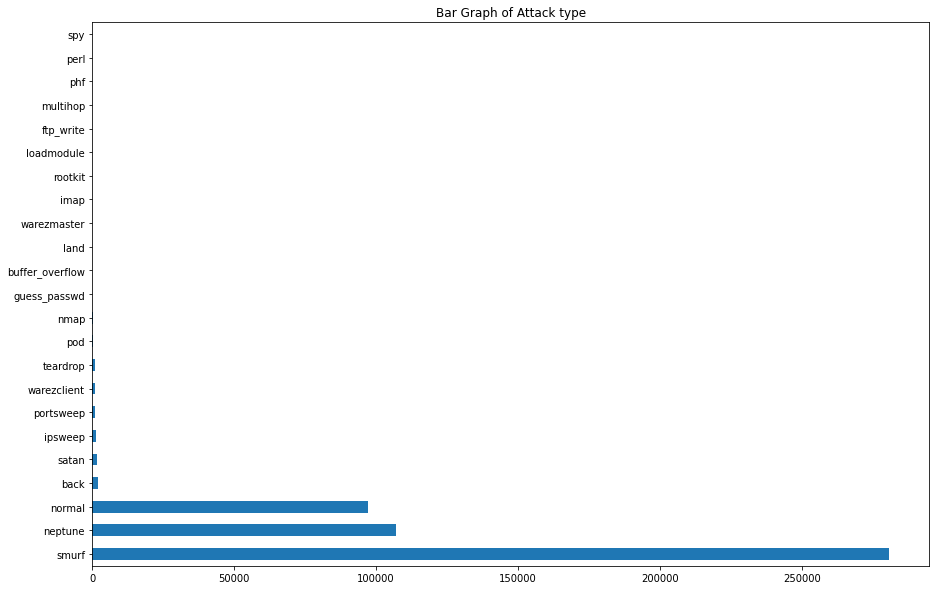

In [120]:
plt.figure(figsize=(15, 10))
plt.title('Bar Graph of Attack type')
kdd99_10p_df['attack_type'].value_counts().plot(kind="barh")
plt.show()

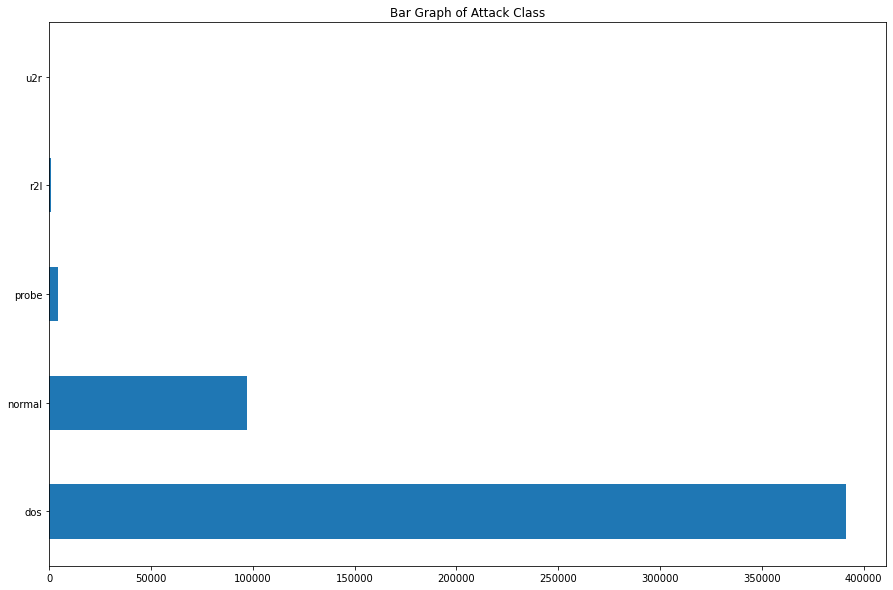

In [119]:
plt.figure(figsize=(15, 10))
plt.title('Bar Graph of Attack Class')
kdd99_10p_df['attack_class'].value_counts().plot(kind="barh")
plt.show()

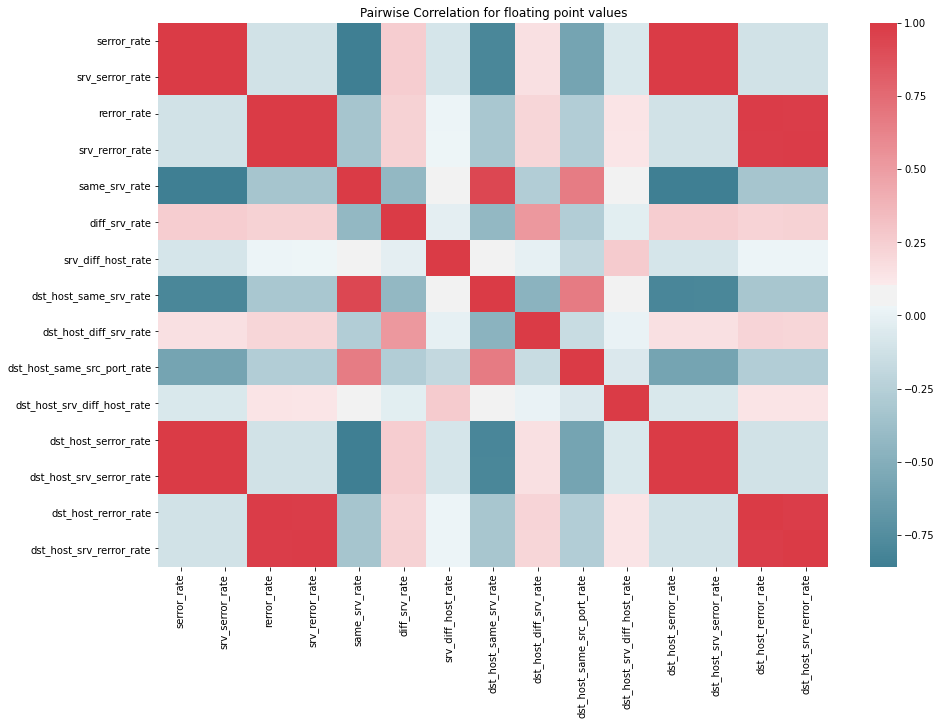

In [125]:
# pairwise correlation for float type values
corr = kdd99_10p_df.loc[:,kdd99_10p_df.dtypes == 'float64'].corr()

plt.figure(figsize = (15,10))
plt.title('Pairwise Correlation for floating point values')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

## Engineering Data
The `DecisionTreeClassifier` needs values that can be coerced into an `ndarray`. This data set has `object`s in it which are just strings. These categorical variables will be encoded as numerics using a simple `LabelEncoder`. 


In [97]:
Y = kdd99_10p_df[['attack_type']]
Y_class = kdd99_10p_df[['attack_class']]
X = kdd99_10p_df.drop(['attack_type',], axis=1)\
                .drop(['attack_class',], axis=1)

encoder_dict = {}

for c in X.columns:
    if X[c].dtype == np.object:
        encoder = LabelEncoder()
        encoder.fit(kdd99_10p_df[c])
        X[c] = encoder.transform(X[c])
        encoder_dict[c] = encoder

X.describe()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,494021.000000,494021.000000,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.0,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,0.467132,23.408894,7.842446,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.285690,292.906557,0.176687,0.176609,0.057433,0.057719,0.791547,0.020982,0.028997,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,0.575606,13.538332,2.250853,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,0.010551,0.007793,2.012718,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147412,246.322817,0.380717,0.381017,0.231623,0.232147,0.388189,0.082205,0.142397,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,14.000000,9.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,14.000000,9.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,42.000000,9.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,511.000000,511.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.000000,65.000000,10.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split data
Data will be split into two equal sets. The samples will be stratified over our target variable, `attack_type`.

In [99]:
x1, x2, y1, y2 = train_test_split(X, Y, test_size=0.5, stratify=Y, random_state=0)

## Decision trees

In [114]:
def make_tree(x, y, xx, yy, export_depth=2):
  dtc = DecisionTreeClassifier(criterion='entropy', random_state=0)
  dtc.fit(x, y)
  print(f'The first set (training) scores {dtc.score(x, y)}')
  print(f'The second set (test) scores {dtc.score(xx, yy)}')
  plt.figure(figsize=(15,10))
  plot_tree(dtc, class_names=dtc.classes_, feature_names=x.columns, filled=True, 
            fontsize=10, max_depth=2, precision=1, label=None, impurity=False)
  plt.show()
  return export_text(dtc, feature_names=list(x.columns), max_depth=export_depth)

['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']
The first set (training) scores 0.9999959515809077
The second set (test) scores 0.9996315953540531


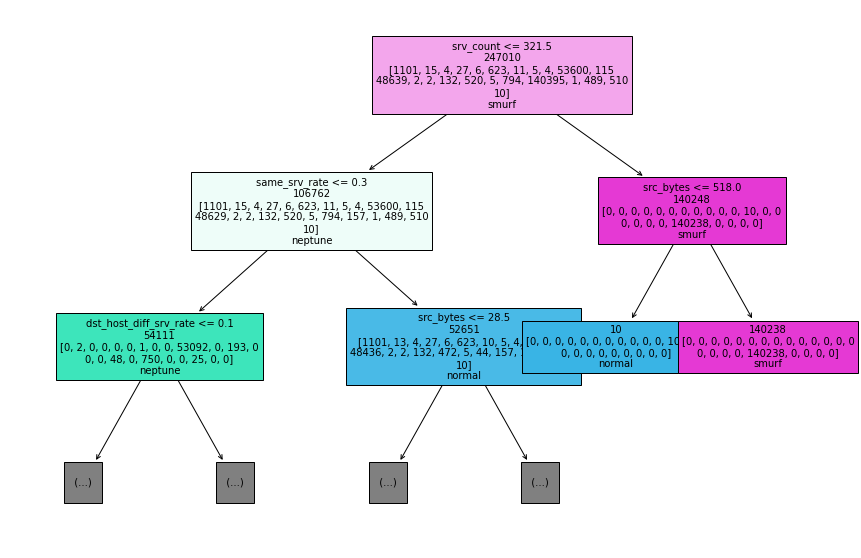

In [108]:
tree_txt = make_tree(x1, y1, x2, y2)

## Decision Tree 2

['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']
The first set (training) scores 1.0
The second set (test) scores 0.9995789644143962


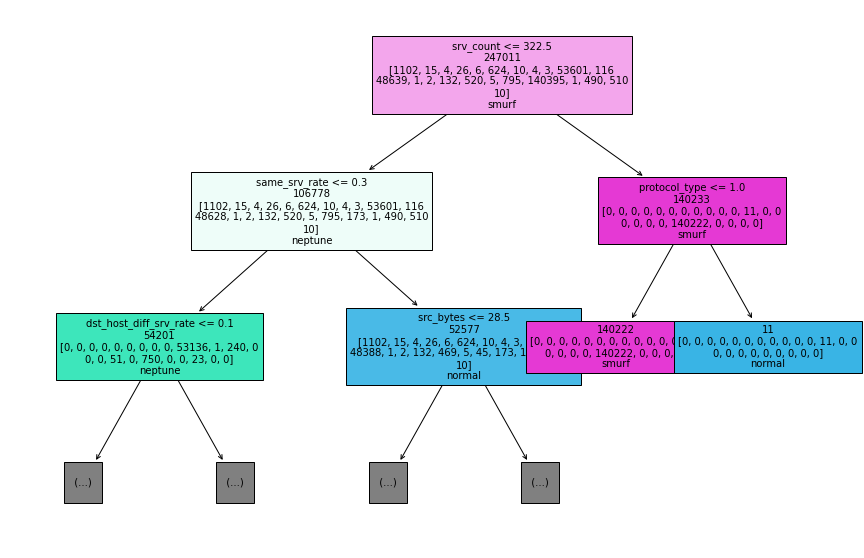

In [109]:
tree_txt2 = make_tree(x2, y2, x1, y1)

## Comparing the Trees

I used `difflib` to create a side-by-side comparison for the two trees. Note that these are not the full trees but the trees truncated to 2 nodes past root. These two trees are very much alike, both starting with `srv_count` as the first decision point. The [task description](http://kdd.ics.uci.edu/databases/kddcup99/task.html) defines `srv_count` as _"number of connections to the same service as the current connection in the past two seconds"_.  It seems that both trees agree that if the serve count exceeds a threshold of about 318 connections then it is likely a __smurf__ attack or normal activity. The two trees differ on this second step with the first tree further classifying the records by `src_bytes` (_"number of data bytes from source to destination"_) and the second tree classifying them with `protocol_type` (_"type of the protocol, e.g. tcp, udp, etc."_). This categorical variable is given in its transformed form in the trees. The transformation map has been given below.


In [111]:
import difflib
from IPython.core.display import display, HTML
d = difflib.HtmlDiff().make_table(tree_txt.split('\n'), tree_txt2.split('\n'),
                                   fromdesc='Tree1', todesc='Tree2')
HTML(d)

In [131]:
p_encoder = encoder_dict['protocol_type']
protocols = list(p_encoder.classes_)
trans = p_encoder.transform(protocols)

for p, t in zip(protocols, trans):
  print(f'{p} -> {t}')

icmp -> 0
tcp -> 1
udp -> 2
